In [115]:
# from google.colab import files
# files.upload()
# !unzip -q digits.zip -d digits/
# !ls digits/ | head -10

In [116]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from torch import no_grad
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')

In [117]:
# — Transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # augmentation
    transforms.ToTensor(),             # [0,255]→[0,1]
    transforms.Normalize((0.5,), (0.5,))  # [0,1]→[-1,1]
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [118]:
# — MNIST loaders
trainset = datasets.MNIST('MNIST_data', train=True, download=True, transform=train_transform)
testset  = datasets.MNIST('MNIST_data', train=False, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset,  batch_size=64, shuffle=False)

In [119]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [120]:
# — Custom digits Dataset
class DigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.root = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = int(fname.split('-')[0])
        img = Image.open(os.path.join(self.root, fname)).convert('L')
        if self.transform:
            img = self.transform(img)
        return img, label

dataset = DigitDataset('digits/digits', transform=test_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

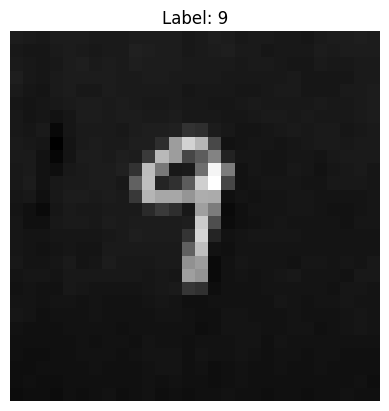

In [121]:
image, label = dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [122]:
#Step 2: Define an MLP Model (Fully Connected Only)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)


In [123]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
error_rates = []

def train_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # training accuracy
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.2f}%")
    return avg_loss, accuracy

def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    print(f" Validation Loss: {avg_loss:.4f}, Validation Acc: {accuracy:.2f}%")
    return avg_loss, accuracy

In [124]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [125]:
# Training loop
num_epochs = 15
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_epoch(model, trainloader, criterion, optimizer, epoch)
    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)

    vl_loss, vl_acc = validate_epoch(model, testloader, criterion)
    val_losses.append(vl_loss)
    val_accuracies.append(vl_acc)
    error_rates.append(100 - vl_acc)

Epoch 1, Train Loss: 0.3647, Train Acc: 88.75%
 Validation Loss: 0.1614, Validation Acc: 94.95%
Epoch 2, Train Loss: 0.1735, Train Acc: 94.55%
 Validation Loss: 0.1487, Validation Acc: 95.10%
Epoch 3, Train Loss: 0.1319, Train Acc: 95.87%
 Validation Loss: 0.1078, Validation Acc: 96.59%
Epoch 4, Train Loss: 0.1131, Train Acc: 96.43%
 Validation Loss: 0.1000, Validation Acc: 96.82%
Epoch 5, Train Loss: 0.0973, Train Acc: 96.94%
 Validation Loss: 0.0833, Validation Acc: 97.35%
Epoch 6, Train Loss: 0.0872, Train Acc: 97.23%
 Validation Loss: 0.0961, Validation Acc: 97.21%
Epoch 7, Train Loss: 0.0801, Train Acc: 97.47%
 Validation Loss: 0.0886, Validation Acc: 97.17%
Epoch 8, Train Loss: 0.0726, Train Acc: 97.64%
 Validation Loss: 0.0968, Validation Acc: 96.91%
Epoch 9, Train Loss: 0.0688, Train Acc: 97.82%
 Validation Loss: 0.0751, Validation Acc: 97.73%
Epoch 10, Train Loss: 0.0658, Train Acc: 97.90%
 Validation Loss: 0.0737, Validation Acc: 97.70%
Epoch 11, Train Loss: 0.0620, Train Acc

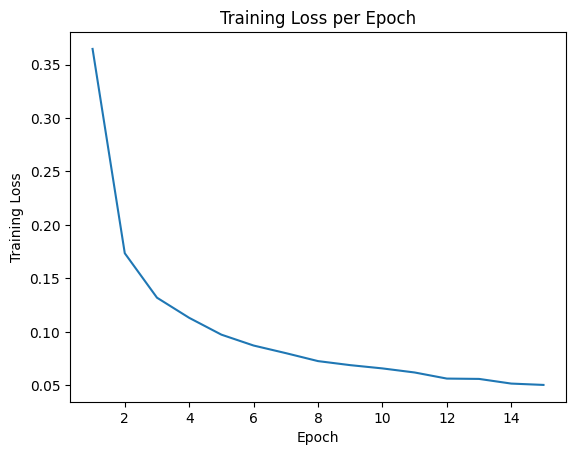

In [126]:
# Plot: Training Loss vs. Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')
plt.show()

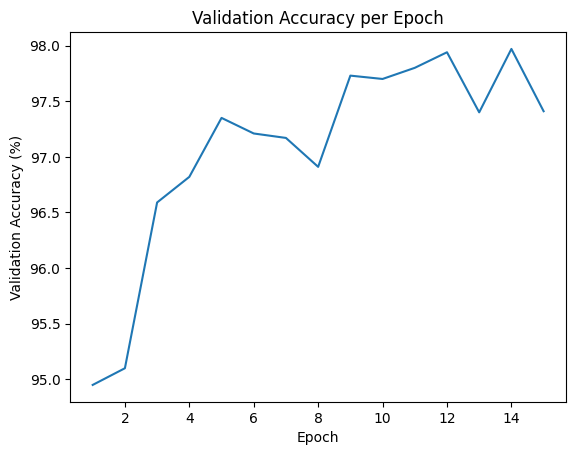

In [127]:
# Plot: Validation Accuracy vs. Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.show()

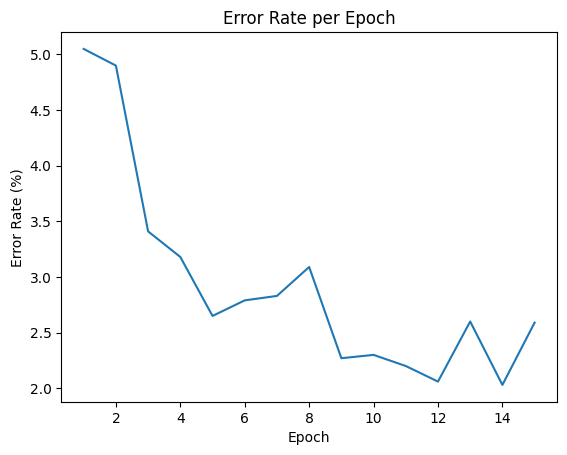

In [128]:
# Plot: Error Rate vs. Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), error_rates)
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate per Epoch')
plt.show()

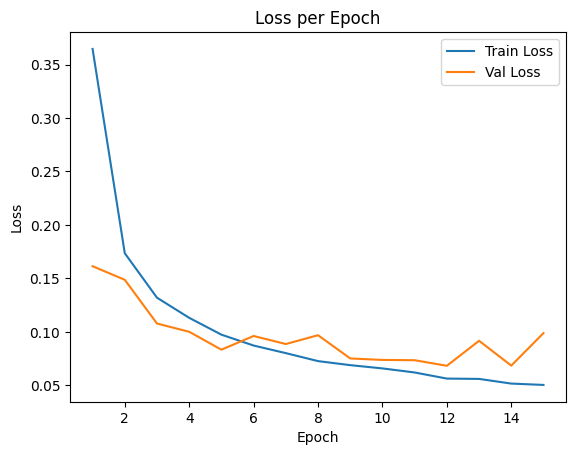

In [129]:

# Plot: Train vs Validation Loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

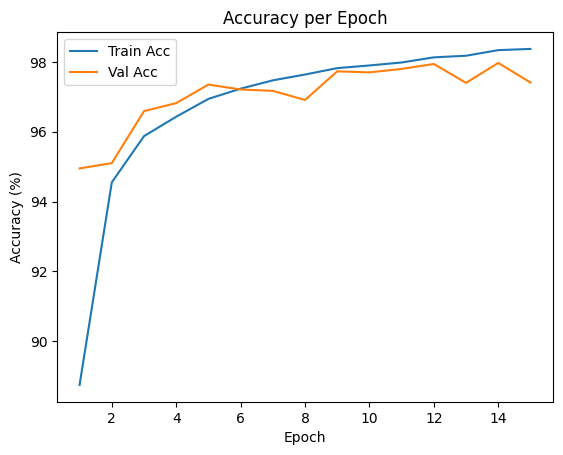

In [130]:
# Plot: Train vs Validation Accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

In [131]:
# 1) MNIST test accuracy & CM
test_loss, test_acc = validate_epoch(model, testloader, criterion)
print(f"MNIST Test Accuracy: {test_acc:.2f}%")

 Validation Loss: 0.0988, Validation Acc: 97.41%
MNIST Test Accuracy: 97.41%


In [132]:
custom_loader = DataLoader(dataset, batch_size=1, shuffle=False)
correct = 0
for img, label in custom_loader:
    output = model(img)
    _, pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

custom_accuracy = 100 * correct / len(dataset)
print(f"Custom Group Digit Accuracy: {custom_accuracy:.2f}%")

Custom Group Digit Accuracy: 34.85%


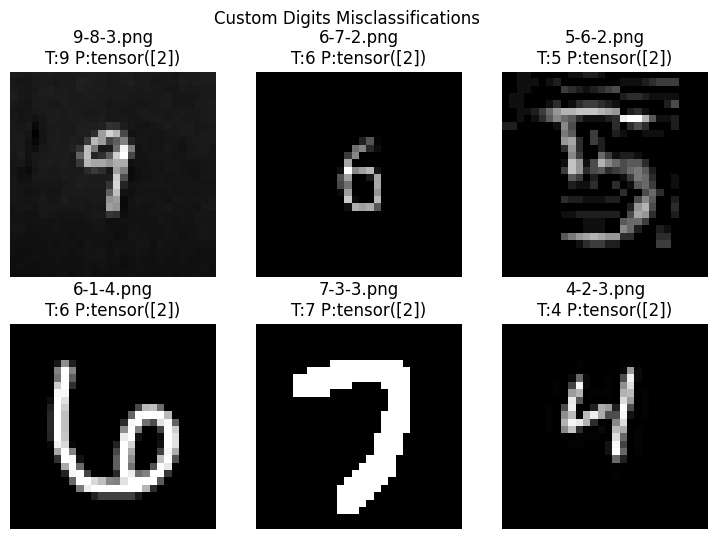

In [133]:
# — Show a few custom misclassified examples
mis = []
model.eval()
with torch.no_grad():
    for idx, (img, lbl) in enumerate(custom_loader):
        _, pred = torch.max(output.data, 1)
        true = lbl.item()
        if pred != true:
            mis.append((img.squeeze().cpu(), true, pred, dataset.files[idx]))
            if len(mis) >= 6:
                break

plt.figure(figsize=(9,6))
for i, (img, true, pred, fname) in enumerate(mis):
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{fname}\nT:{true} P:{pred}")
    plt.axis('off')
plt.suptitle("Custom Digits Misclassifications")
plt.show()


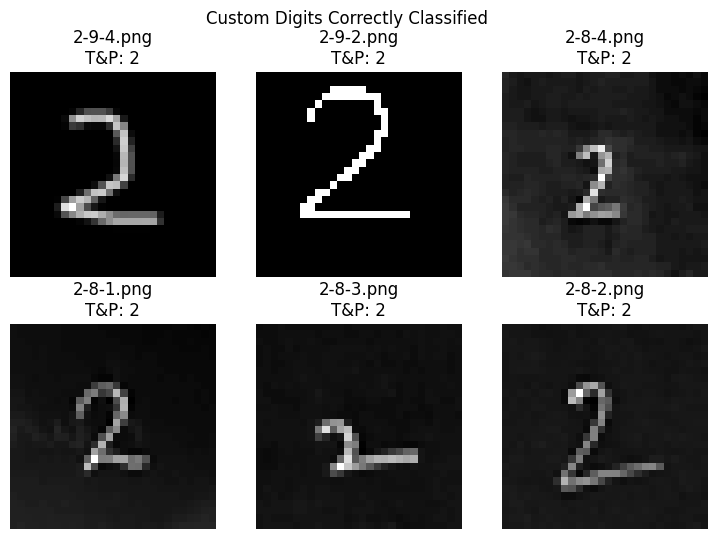

In [134]:
# — Show a few custom correctly classified examples
correct_examples = []
model.eval()
with torch.no_grad():
    for idx, (img, lbl) in enumerate(custom_loader):
        _, pred = torch.max(output.data, 1)
        true = lbl.item()
        if pred == true:
            correct_examples.append((img.squeeze().cpu(), true, pred, dataset.files[idx]))
            if len(correct_examples) >= 6:
                break

plt.figure(figsize=(9,6))
for i, (img, true, pred, fname) in enumerate(correct_examples):
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{fname}\nT&P: {true}")
    plt.axis('off')
plt.suptitle("Custom Digits Correctly Classified")
plt.show()


In [135]:
preds = []
model.eval()
with no_grad():
    for img, _ in custom_loader:         
        out = model(img)
        p = out.argmax(dim=1).item()
        preds.append(p)

pred_counts = pd.Series(preds).value_counts().sort_index()

fig_pred = px.bar(
    x=pred_counts.index,
    y=pred_counts.values,
    labels={'x':'Predicted Digit','y':'Count'},
    title='Predicted Label Distribution on Custom Digit Dataset'
)
fig_pred.update_layout(xaxis=dict(tickmode='linear'))
fig_pred.show()


In [136]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in custom_loader:  
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
correct_counts = np.diag(cm)  

fig = px.bar(
    x=list(range(10)),
    y=correct_counts,
    labels={'x':'Digit','y':'# Correct Predictions'},
    title='Correct Predictions by Digit'
)
fig.update_layout(xaxis=dict(tickmode='linear'))
fig.show()


## Improvement 1: Add Data Augmentation and Preprocessing

In [137]:

transform = transforms.Compose([
    transforms.Resize((28, 28)),                  # Resize to MNIST size
    transforms.Grayscale(),                       # Ensure grayscale
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Shift & rotate
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## Improvement 2: Add Dropout Layers to Your MLP

In [138]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)


# Improvement 3: Try a Learning Rate Scheduler

In [139]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

for epoch in range(1, 15):
    train_epoch(model, trainloader, criterion, optimizer, epoch)
    val_loss, val_acc = validate_epoch(model, testloader, criterion)
    scheduler.step()
    print(f"Validation Accuracy: {val_acc:.2f}%")


Epoch 1, Train Loss: 0.0504, Train Acc: 98.34%
 Validation Loss: 0.0797, Validation Acc: 97.82%
Validation Accuracy: 97.82%
Epoch 2, Train Loss: 0.0445, Train Acc: 98.57%
 Validation Loss: 0.0763, Validation Acc: 97.87%
Validation Accuracy: 97.87%
Epoch 3, Train Loss: 0.0265, Train Acc: 99.12%
 Validation Loss: 0.0649, Validation Acc: 98.21%
Validation Accuracy: 98.21%
Epoch 4, Train Loss: 0.0249, Train Acc: 99.19%
 Validation Loss: 0.0656, Validation Acc: 98.27%
Validation Accuracy: 98.27%
Epoch 5, Train Loss: 0.0173, Train Acc: 99.44%
 Validation Loss: 0.0568, Validation Acc: 98.60%
Validation Accuracy: 98.60%
Epoch 6, Train Loss: 0.0154, Train Acc: 99.50%
 Validation Loss: 0.0568, Validation Acc: 98.49%
Validation Accuracy: 98.49%
Epoch 7, Train Loss: 0.0124, Train Acc: 99.60%
 Validation Loss: 0.0560, Validation Acc: 98.52%
Validation Accuracy: 98.52%
Epoch 8, Train Loss: 0.0119, Train Acc: 99.63%
 Validation Loss: 0.0559, Validation Acc: 98.56%
Validation Accuracy: 98.56%
Epoch 9,

In [140]:
custom_loader  = DataLoader(dataset, batch_size=16, shuffle=True)

for epoch in range(3):  
    for img, label in custom_loader:
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

## Final Evaluation (After Improvements)

In [141]:
correct = 0
for img, label in custom_loader:
    output = model(img)
    _, pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

custom_accuracy = 100 * correct / len(dataset)
print(f"Custom Group Digit Accuracy: {custom_accuracy:.2f}%")


Custom Group Digit Accuracy: 49.70%


In [142]:
preds = []
model.eval()
with no_grad():
    for imgs, _ in custom_loader:
        out = model(imgs)                         
        batch_preds = out.argmax(dim=1).tolist()  
        preds.extend(batch_preds)
pred_counts = pd.Series(preds).value_counts().sort_index()

fig_pred = px.bar(
    x=pred_counts.index,
    y=pred_counts.values,
    labels={'x':'Predicted Digit','y':'Count'},
    title='Predicted Label Distribution on Custom Digit Dataset'
)
fig_pred.update_layout(xaxis=dict(tickmode='linear'))
fig_pred.show()


In [143]:
y_true, y_pred = [], []
model.eval()
with no_grad():
    for imgs, labels in custom_loader:
        out = model(imgs)
        preds = out.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
correct_counts = np.diag(cm)

fig_corr = px.bar(
    x=list(range(10)),
    y=correct_counts,
    labels={'x':'Digit', 'y':'# Correct Predictions'},
    title='Correct Predictions by Digit on Custom Dataset'
)
fig_corr.update_layout(xaxis=dict(tickmode='linear'))
fig_corr.show()


### Extra Enhancement

In [144]:
#Update the transform

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.9, 1.1)),
    transforms.RandomInvert(p=0.2),  # randomly invert pixels
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [145]:
prec, rec, _, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(10))
df = pd.DataFrame({'Digit':range(10),'Precision':prec,'Recall':rec})
fig = px.bar(df.melt(id_vars='Digit'), x='Digit', y='value', color='variable',
             barmode='group', title='Precision vs Recall by Digit')
fig.show()


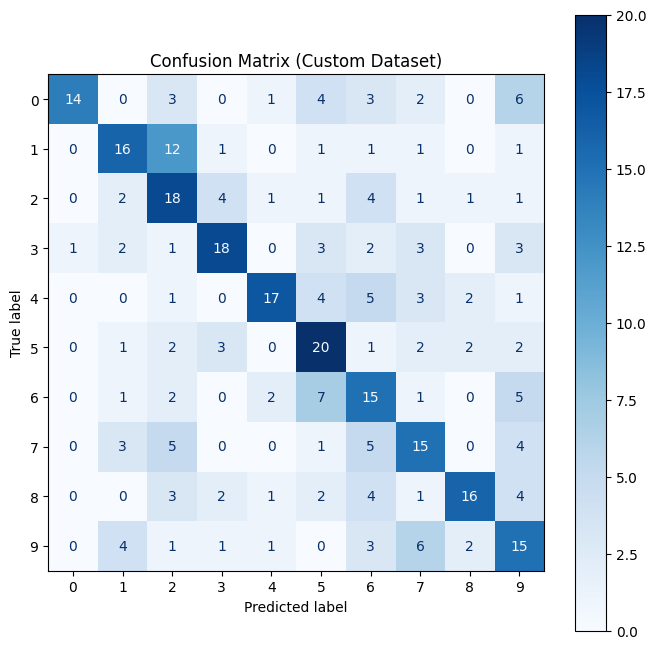

In [146]:
y_true, y_pred = [], []
model.eval()
with no_grad():
    for imgs, labels in custom_loader:
        out   = model(imgs)
        preds = out.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.set_title("Confusion Matrix (Custom Dataset)")
plt.show()


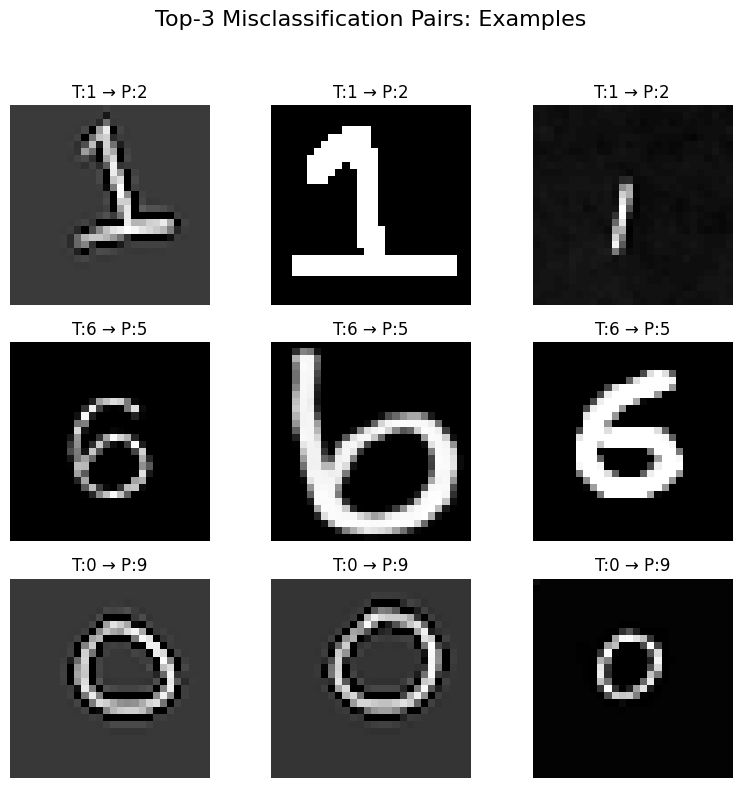

In [147]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
pairs = []
for i in range(10):
    for j in range(10):
        if i != j:
            pairs.append(((i,j), cm[i,j]))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:3]
examples = []
for (true, pred), _ in pairs:
    count = 0
    for imgs, labels in custom_loader:
        out = model(imgs)
        preds = out.argmax(dim=1)
        for img, lbl, p in zip(imgs, labels, preds):
            if lbl.item()==true and p.item()==pred and count<3:
                examples.append((img.squeeze().cpu().numpy(), true, pred))
                count += 1
        if count>=3:
            break
fig, axes = plt.subplots(3,3, figsize=(8,8))
fig.suptitle("Top-3 Misclassification Pairs: Examples", fontsize=16)
for idx, (img, t, p) in enumerate(examples):
    r, c = divmod(idx, 3)
    ax = axes[r,c]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"T:{t} → P:{p}")
    ax.axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


## Train a Bigger MLP

In [148]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(self.flatten(x))


## Fine-tune Longer (15 epochs)


In [156]:
for epoch in range(15):
    for img, label in custom_loader:
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

## Use Learning Rate Warm-Up + Lower LR for Fine-tuning


In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

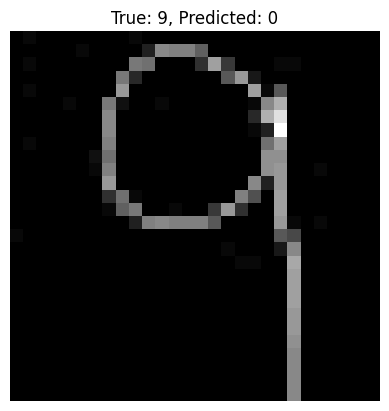

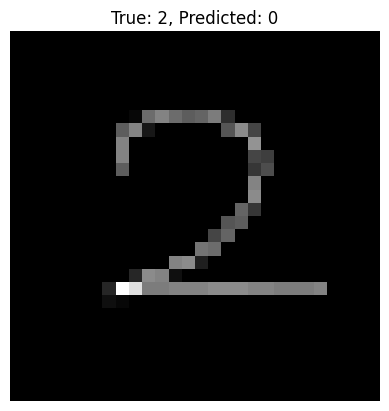

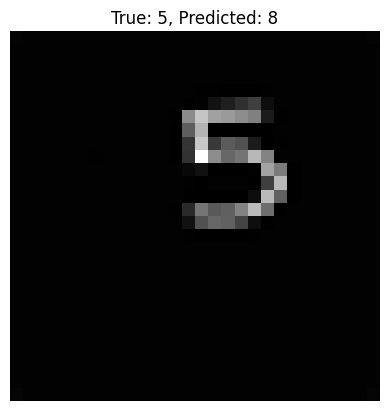

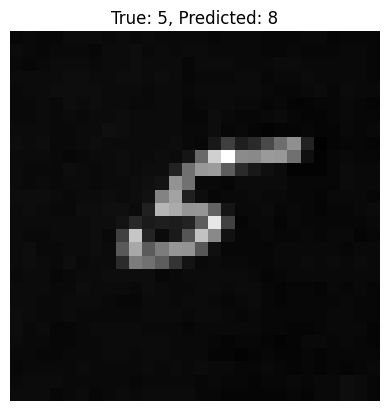

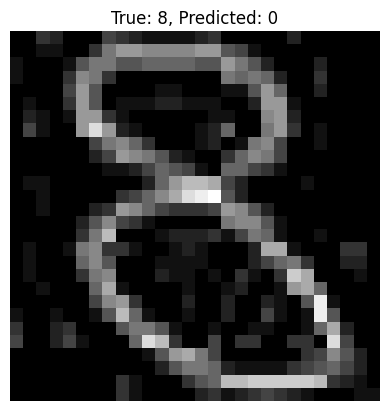

In [158]:
wrong = []

for imgs, labels in custom_loader:
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    for img, label, pred in zip(imgs, labels, preds):
        if label != pred:
            wrong.append((img.squeeze(), label.item(), pred.item()))
for img, true_label, pred_label in wrong[:5]:
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {pred_label}')
    plt.axis('off')
    plt.show()



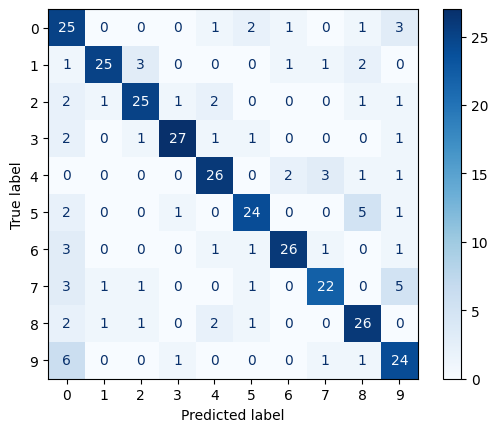

In [159]:
#Use a Confusion Matrix
y_true = []
y_pred = []

for imgs, labels in custom_loader:
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)

    for label, pred in zip(labels, preds):
        y_true.append(label.item())
        y_pred.append(pred.item())


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
accuracy = accuracy_score(y_true, y_pred)

In [160]:
print(f"Custom Digits Accuracy (after confusion matrix): {accuracy * 100:.2f}%")

Custom Digits Accuracy (after confusion matrix): 75.76%


In [161]:
preds = []
model.eval()
with no_grad():
    for imgs, _ in custom_loader:
        out = model(imgs)
        batch = out.argmax(dim=1).tolist()
        preds.extend(batch)
pred_counts = pd.Series(preds).value_counts().sort_index()
fig = px.bar(
    x=pred_counts.index,
    y=pred_counts.values,
    labels={'x':'Predicted Digit','y':'Count'},
    title='Predicted Label Distribution on Custom Digit Dataset (New MLP)'
)
fig.update_layout(xaxis=dict(tickmode='linear'))
fig.show()


In [162]:
y_true, y_pred = [], []
model.eval()
with no_grad():
    for imgs, labels in custom_loader:
        out = model(imgs)
        preds = out.argmax(dim=1).tolist()
        y_pred.extend(preds)
        y_true.extend(labels.tolist())

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
correct_counts = np.diag(cm)

fig1 = px.bar(
    x=list(range(10)),
    y=correct_counts,
    labels={'x':'Digit','y':'# Correct Predictions'},
    title='Raw Correct Predictions by Digit (New MLP)'
)
fig1.update_layout(xaxis=dict(tickmode='linear'))
fig1.show()
class_totals = cm.sum(axis=1)
class_acc = 100 * correct_counts / class_totals

fig2 = px.bar(
    x=list(range(10)),
    y=class_acc,
    labels={'x':'Digit','y':'Accuracy (%)'},
    title='Per-Class Accuracy (%) on Custom Dataset (New MLP)'
)
fig2.update_layout(xaxis=dict(tickmode='linear'), yaxis=dict(range=[0,100]))
fig2.show()
